In [1]:
using Random
using Distributions
using LinearAlgebra
using ForwardDiff
using KernelDensity
include("../Inversion/Plot.jl")
include("../Inversion/KalmanInversion.jl")

solve_β (generic function with 2 methods)

# 1-Parameter Square Map
The posterior distribution is studied  numerically on the following nonlinear 1-parameter problem:

$$
\begin{equation*}
y = \mathcal{G}(\theta) + \eta \qquad \mathcal{G}(\theta) = \theta^2. 
\end{equation*}
$$    


We assume the observation is $y = 1$ and the piror is $\mathcal{N}(3, 2^2)$, we consider the following cases

$$
\begin{align*}
&A: \eta \sim \mathcal{N}(0, 1^2)\\
&B: \eta \sim \mathcal{N}(0, 0.5^2)\\
&C: \eta \sim \mathcal{N}(0, 0.2^2)\\
\end{align*}
$$ 

In [2]:
mutable struct Setup_Param{IT<:Int}
    θ_names::Array{String,1}
    N_θ::IT
    N_y::IT
end

function Setup_Param(N_θ::IT, N_y::IT) where {IT<:Int}
    return Setup_Param(["θ"], N_θ, N_y)
end

function p1(s_param, θ)  
    return [θ[1] ;]
end

function p1_aug(s_param, θ)  
    return [θ[1] ; θ[1]]
end

function p1_aug_derivative(s_param, θ)  
    return [θ[1] ; θ[1]], [1.0 ; 1.0]
end



function p2(s_param, θ)  
    return [θ[1]^2 ;]
end

function p2_aug(s_param, θ)  
    return [θ[1]^2 ; θ[1]]
end

function p2_aug_derivative(s_param, θ)  
    return [θ[1]^2 ; θ[1]], [2θ[1] ; 1.0]
end

p2_aug_derivative (generic function with 1 method)

In [13]:
function Posterior_Plot(forward::Function;  θ_ref = 1.0, σ_η = 1.0, μ_0 = 3.0,  σ_0 = 2.0, mixture_power_sampling_method = "random-sampling",
                        plot_every = 1)

    forward_aug = (s_param, θ) -> vcat(forward(s_param, θ), θ)
    
    N_y, N_θ = 1, 1
    s_param = Setup_Param(N_θ, N_y)
    y = forward(s_param, [θ_ref;])
    Σ_η = reshape([σ_η^2], (N_y, N_y))
    # prior distribution
    μ0,  Σ0   = [μ_0;], reshape([σ_0^2],  (N_θ, N_θ))
    
    
    
    # compute posterior distribution by GMKI
    update_freq = 1
    N_iter = 30
    
    s_param_aug = Setup_Param(1,2)
    y_aug = [y ; μ0]
    Σ_η_aug = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y) Σ0]
    Δt = 0.5
    
    gmkiobjs = [] 
    for N_modes = 1:3
        
        θ0_w  = fill(1.0, N_modes)/N_modes
        θ0_mean, θθ0_cov  = zeros(N_modes, N_θ), zeros(N_modes, N_θ, N_θ)

        Random.seed!(111);
        for m = 1:N_modes
            θ0_mean[m, :]    .= rand(Normal(0, σ_0), N_θ)
            θθ0_cov[m, :, :] .= Array(Diagonal(fill(σ_0^2, N_θ)))
        end
        @info "Run GMKI with ", N_modes, " θ0_mean = ", θ0_mean
        gmkiobj = GMKI_Run(s_param_aug, forward_aug, θ0_w, θ0_mean, θθ0_cov, y_aug, Σ_η_aug, Δt, update_freq, N_iter; unscented_transform="modified-2n+1", mixture_power_sampling_method = mixture_power_sampling_method, w_min=1e-10)
        push!(gmkiobjs, gmkiobj) 
    
    end


        
    Nx = 1000
    θ_min = minimum(gmkiobjs[end].θ_mean[end][:,1] .- 5sqrt.(gmkiobjs[end].θθ_cov[end][:,1,1]))
    θ_max = maximum(gmkiobjs[end].θ_mean[end][:,1] .+ 5sqrt.(gmkiobjs[end].θθ_cov[end][:,1,1]))
    θ_min = min(θ_min, -4.0);   θ_max = max(θ_max, 4.0)  
    
    # Plot reference
    xx_ref = Array(LinRange(θ_min, θ_max, 1000))
    dx = xx_ref[2] - xx_ref[1]
    yy_ref = copy(xx_ref)
    for i = 1:length(xx_ref)
        y_pred = forward(s_param, [xx_ref[i];])[1]
        yy_ref[i] = exp( - 0.5*(y_pred - y[1])^2/σ_η^2  - 0.5*(xx_ref[i] - μ_0)^2/σ_0^2 )
    end
    yy_ref .= yy_ref / ( sum(yy_ref)*(xx_ref[2] - xx_ref[1]) )
           
    
    # visualization 
    plot_every = 10
    linestyles = ["o"; "x"; "s"]
    
    
    iter = N_iter+1
    fig, ax = PyPlot.subplots(nrows=1, ncols= 4, sharex=false, sharey=false, figsize=(16,4))

    # plot UKI results 
    for N_modes = 1:3
        
        
        error = zeros(N_iter+1)
        Nx = 1000
        for iter = 0:N_iter  
            # Plot reference
            
            xx, yy_preds = zeros(Nx), zeros(N_modes, Nx)
            for i =1:N_modes
                xx, yy_preds[i, :] = Gaussian_1d(gmkiobjs[N_modes].θ_mean[iter+1][i,1], gmkiobjs[N_modes].θθ_cov[iter+1][i,1,1], Nx, θ_min, θ_max)
                yy_preds[i, :] *= exp(gmkiobjs[N_modes].logθ_w[iter+1][i])    
            end 
            yy_pred = sum(yy_preds, dims=1)'     #' 
            # compute TV error
            error[iter+1] = norm(yy_pred - yy_ref,1)*dx
        
            if iter == N_iter
                ax[N_modes].plot(xx_ref, yy_ref, "-s", label="Reference", color="grey", linewidth=2, fillstyle="none", markevery=25)
                ax[N_modes].plot(xx_ref, yy_pred, linestyle="-", color="C0", fillstyle="none", markevery=100, label="GMKI", linewidth=2)
                ax[N_modes].legend()
                for i =1:N_modes
                    # final mean positions
                    ax[N_modes].plot(fill(gmkiobjs[N_modes].θ_mean[iter+1][i,1], 11), LinRange(0,1,11), marker=linestyles[i], fillstyle="none", markevery=5, color="C"*string(i))
                    # initial mean positions
                    ax[N_modes].plot(fill(gmkiobjs[N_modes].θ_mean[1][i,1], 11), LinRange(0,1,11), "--", marker=linestyles[i], fillstyle="none", markevery=5, color="black")
                end
            
            
                ax[4].plot(Array(0:N_iter), error, label="(K="*string(N_modes)*")")
            end
        end
        
    end
            
            
    ax[4].legend() 
    ax[4].set_xlabel("Iterations")
    ax[4].set_ylabel("TV distance")
    ax[1].set_xlim([-2.5, 2.5])
    ax[1].set_xlabel("θ")
    ax[1].set_ylabel("Density")
    ax[2].set_xlim([-2.5, 2.5])
    ax[2].set_xlabel("θ")
    ax[2].set_yticks([])
    ax[3].set_xlim([-2.5, 2.5])
    ax[3].set_xlabel("θ")
    ax[3].set_yticks([])
    fig.tight_layout()
    fig.savefig("1D-density-"*string(σ_η)*"-"*string(N_iter)*".pdf")

    
    
end

mixture_power_sampling_method = "random-sampling"

"random-sampling"

[ Info: ("Run GMKI with ", 1, " θ0_mean = ", [-2.4283140297584804;;])
[ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
[ Info: ("Run GMKI with ", 2, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095;;])
[ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
[ Info: ("Run GMKI with ", 3, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095; -0.894645096090581;;])
[ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 


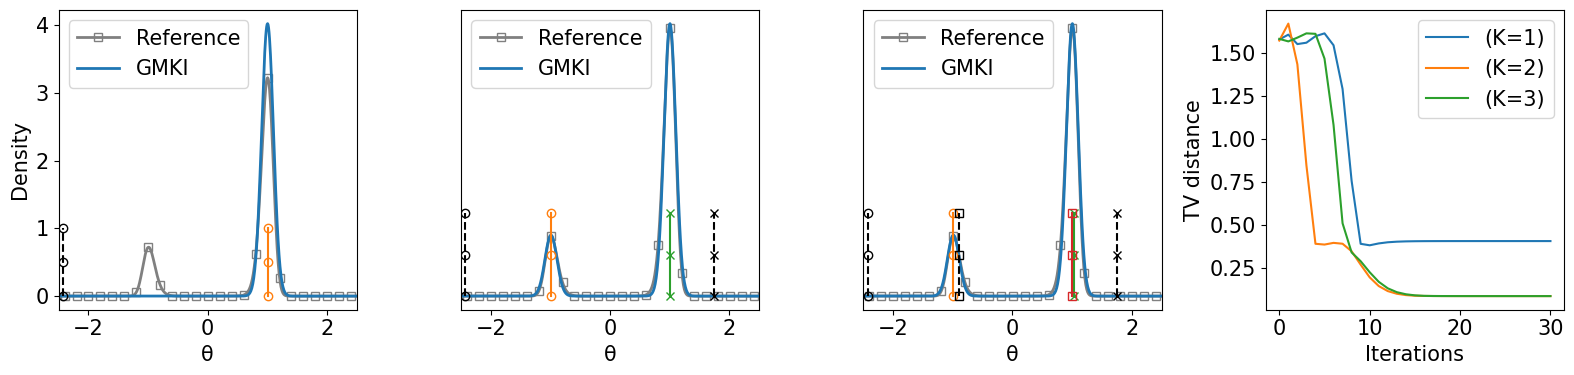

In [14]:
Posterior_Plot(p2; θ_ref = 1.0, σ_η = 0.2, μ_0 = 3.0,  σ_0 = 2.0, mixture_power_sampling_method = mixture_power_sampling_method) 

[ Info: ("Run GMKI with ", 1, " θ0_mean = ", [-2.4283140297584804;;])
[ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
[ Info: ("Run GMKI with ", 2, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095;;])
[ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
[ Info: ("Run GMKI with ", 3, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095; -0.894645096090581;;])
[ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 


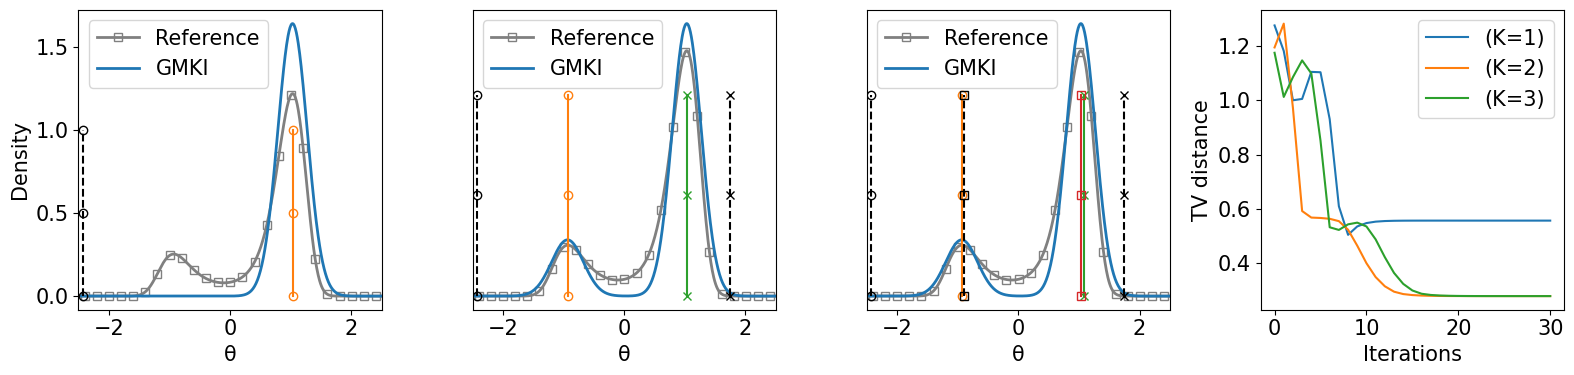

In [15]:
Posterior_Plot(p2; θ_ref = 1.0, σ_η = 0.5, μ_0 = 3.2,  σ_0 = 2.0, mixture_power_sampling_method = mixture_power_sampling_method) 

[ Info: ("Run GMKI with ", 1, " θ0_mean = ", [-2.4283140297584804;;])
[ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
[ Info: ("Run GMKI with ", 2, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095;;])
[ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
[ Info: ("Run GMKI with ", 3, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095; -0.894645096090581;;])
[ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 


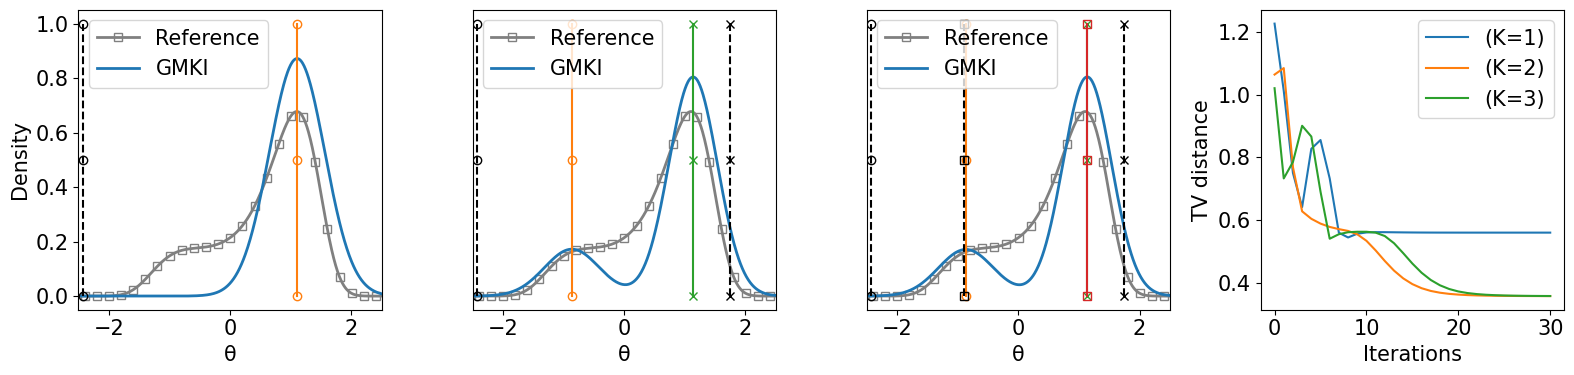

In [16]:
Posterior_Plot(p2; θ_ref = 1.0, σ_η = 1.0, μ_0 = 3.0,  σ_0 = 2.0,  mixture_power_sampling_method = mixture_power_sampling_method) 

[ Info: ("Run GMKI with ", 1, " θ0_mean = ", [-2.4283140297584804;;])
[ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
[ Info: ("Run GMKI with ", 2, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095;;])
[ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
[ Info: ("Run GMKI with ", 3, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095; -0.894645096090581;;])
[ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 


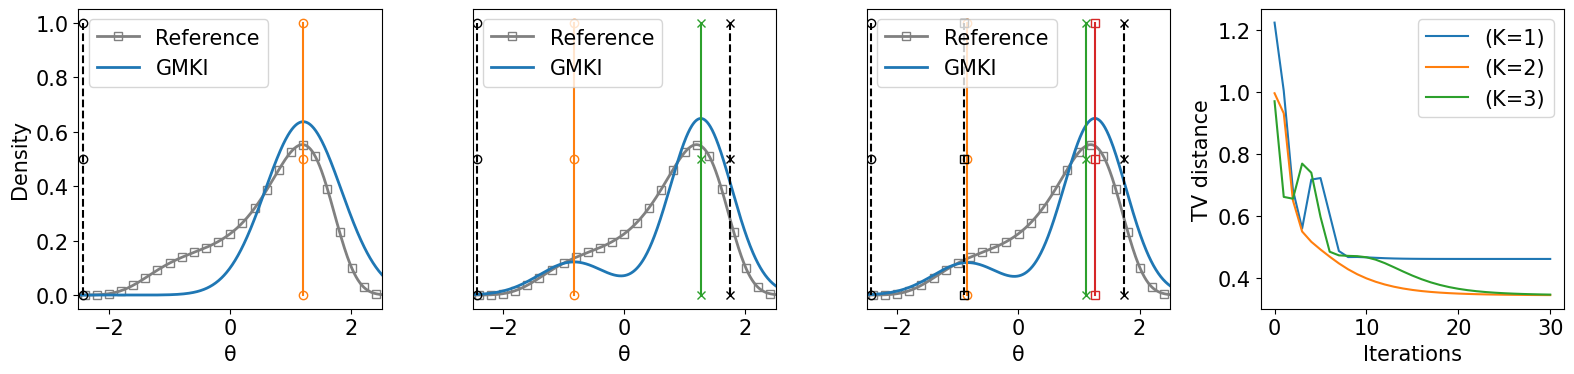

In [17]:
Posterior_Plot(p2; θ_ref = 1.0, σ_η = 1.5, μ_0 = 3.0,  σ_0 = 2.0, mixture_power_sampling_method = mixture_power_sampling_method) 